<a href="https://colab.research.google.com/github/donnedarnall/crop_weed_stem_classification/blob/main/CNN%2BConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 - Set up environment

import libraries, define global variables, etc



In [ ]:
import numpy as np
import tensorflow as tf
import time

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, TimeDistributed, ConvLSTM2D, Activation
from keras.losses import binary_crossentropy
from keras import metrics
from keras import optimizers
from keras.utils import Sequence
from keras import backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from os import listdir, path

from os import listdir, path
from google.colab import drive

mp = "/content/drive/"
drive.mount(mp)

WEEK_ID = '33'
CAM = 'overhead'
WIDTH  = int(512)
HEIGHT = int(384)
SEQ_LENGTH = 2

batch_size = 1
epochs = 10

# Set the seed value of the random number generator
random_seed = 2
np.random.seed(random_seed)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Step 2 - Define preprocessing functions

Borrowed from bonnet/plant_feature.py


In [ ]:
def contrast_stretch(img):
    #Performs contrast stretch to remove extreme outliers in img
    in_min = np.percentile(img, 1)
    in_max = np.percentile(img, 99)

    out_min = 0.0
    out_max = 255.0

    out = img - in_min
    out *= out_max / (in_max - in_min)
    out += out_min

    out[out < out_min] = out_min
    out[out > out_max] = out_max

    return out

def channelwise_norm(img):
    #Performs contrast stretch on each channel
    out = np.array(img)
    for i in range(img.shape[2]):
        out[:, :, i] = contrast_stretch(out[:, :, i].astype(float))

    return out

# Step 3 - Define file handle helpers and load images

Trying to keep this OS independant, as simple as possible. Just pass the basepath and get the absolute filenames from it (no recursion down the basepath).  Reading the files is done with keras image processing functionality, largely borrowed this code from Jason Brownlee; see comments.

In [ ]:
def getImgFiles(basepath, cam):
    files = []
    ld = listdir(basepath)
    ld.sort()
    for entry in ld:
        if path.isfile(path.join(basepath, entry)):
            if cam in entry:
                fn = path.join(basepath, entry)
                files.append(fn)
    return files

def load_images(size=(HEIGHT,WIDTH)):
    # Borrowed from: How to Develop a Pix2Pix GAN for Image-to-Image Translation
    # by Jason Brownlee on August 2, 2019 in Generative Adversarial Networks
    # on Aug 27, 2019.
    # https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

    # Define the keywords, paths wrt the 'standard' Nexus weekly data set
    img_bp   = mp+"My Drive/NEXUS/Nexus Week " + WEEK_ID + " (Complete)/img"
    label_bp = mp+"My Drive/NEXUS/Nexus Week " + WEEK_ID + " (Complete)/labels/"
    stem_bp  = mp+"My Drive/NEXUS/Nexus Week " + WEEK_ID + " (Complete)/stems_labels/"

    # Get the absolute filenames for images of interest
    img_f   = getImgFiles(img_bp,   CAM)
    stem_f  = getImgFiles(stem_bp,  CAM)

    img_list, stem_list = list(), list()
    img_seq_list, stem_seq_list = list(), list()

    # enumerate filenames in directory, assume all are images
    for i in range(4):
        # load and resize the image
        img_pixels  = load_img(img_f[i],  target_size=size)
        stem_pixels = load_img(stem_f[i], target_size=size)

        #convert input img to np array and preprocess
        stretched_input = channelwise_norm(img_to_array(img_pixels))
        stretched_input /= 255.0  #normalizing pixel values between 0 and 1

        #convert stem label img to np array, extract red channel (weeds) and normalize pixel values
        stem_array = img_to_array(stem_pixels)
        stem_array /= 255.0
        stem_array = np.round(stem_array)
        red_stems = stem_array[:, :, 0]

        img_list.append(stretched_input)
        stem_list.append(stem_array)

    stem_list = np.asarray(stem_list)
    stem_list = stem_list[SEQ_LENGTH-1:, :, :, :]

    for i in range(len(img_list)-(SEQ_LENGTH-1)):
        img_seq = list()
        for j in range(SEQ_LENGTH):
            img_seq.append(img_list[i+j])
        img_seq = np.stack(img_seq, axis=0)
        img_seq_list.append(img_seq)
        #stem_seq_list.append(stem_seq)

    return [np.asarray(img_seq_list), np.asarray(stem_list)]

print('Image load functionality ready!')

[X, y] = load_images()

print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('----------------')

n_imgs = len(X)
x_train = X[:2,:, :, :]
y_train = y[:2,:, :, :]
x_test = X[2:, :, :, :]
y_test = y[2:, :, :, :]

print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)

Image load functionality ready!
X shape:  (3, 2, 384, 512, 3)
y shape:  (3, 384, 512, 3)
----------------
x_train:  (2, 2, 384, 512, 3)
y_train:  (2, 384, 512, 3)
x_test:  (1, 2, 384, 512, 3)
y_test:  (1, 384, 512, 3)


# Step 4 - Configure conv network

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(filters=16, kernel_size=(3, 3),
                 padding='same',
                 activation='relu',
                 input_shape=(SEQ_LENGTH, HEIGHT, WIDTH, 3))))
model.add(Dropout(0.2))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))


model.add(ConvLSTM2D(128, (3, 3), padding='same', return_sequences=True))


model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(UpSampling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model.add(Dropout(0.2))
model.add(TimeDistributed(UpSampling2D((2, 2))))

model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(UpSampling2D((2, 2))))

model.add(ConvLSTM2D(3, (3, 3), padding='same', return_sequences=False))
#model.add(TimeDistributed(Conv2D(3,(3, 3), padding='same', activation='softmax')))
model.add(Activation('softmax'))


# Step 5 - Error Metrics

In [ ]:
#Borrowed from Unet
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
def weed_detection_rate(y_true, y_pred):
    #obtaining red channel for weed detection
    true_slice = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
    pred_slice = tf.slice(y_pred, [0, 0, 0, 0], [-1, -1, -1, 1])

    #round pixel values to nearest int (0 or 1)
    true_rounded = tf.math.round(true_slice)
    pred_rounded = tf.math.round(pred_slice)

    #Determine number of pixels correctly labelled as weed stem in predicted image
    product = tf.math.multiply(true_rounded, pred_rounded)
    correct_pred = K.sum(product)
    #Number of pixels in weed class in label image
    true_stems = K.sum(true_rounded)

    return correct_pred/true_stems

In [ ]:
def detection_rate(y_true, y_pred, label):
    #obtaining red channel for weed detection or green channel for crop detection
    if label == "weed":
        true_slice = y_true[:, :, :, 0]
        pred_slice = y_pred[:, :, :, 0]

    elif label == "crop":
        true_slice = y_true[:, :, :, 1]
        pred_slice = y_pred[:, :, :, 1]

    #round pixel values to nearest int (0 or 1)
    true_rounded = np.round(true_slice)
    pred_rounded = np.round(pred_slice)

    #Determine number of pixels labelled correctly in predicted image
    product = np.multiply(true_rounded, pred_rounded)
    correct_pred = np.sum(product)

    #Number of pixels with given class in label image
    true_stems = np.sum(true_rounded)

    return float(correct_pred)/float(true_stems)

In [ ]:
def iou_loss_core(y_true, y_pred):
    smooth = K.epsilon()

    true_red = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
    pred_red = tf.slice(y_pred, [0, 0, 0, 0], [-1, -1, -1, 1])

    true_green = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
    pred_green = tf.slice(y_pred, [0, 0, 0, 1], [-1, -1, -1, 1])

    inter_red = K.sum(K.abs(true_red * pred_red))
    union_red = K.sum(true_red) + K.sum(pred_red) - inter_red
    iou_red = (inter_red + smooth) / (union_red + smooth)

    inter_green = K.sum(K.abs(true_green * pred_green))
    union_green = K.sum(true_green) + K.sum(pred_green) - inter_green
    iou_green = (inter_green + smooth) / (union_green + smooth)

    return 1 - (0.5*iou_red + 0.5*iou_green)

# Step 6 - Compile and fit data to model

In [ ]:
adam = optimizers.Adam(lr=0.0001)
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coeff])
model.compile(optimizer=adam, loss=iou_loss_core, metrics=[dice_coeff])
#model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss, 'accuracy'])

start_train_time = time.time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)
train_time = time.time() - start_train_time
print("Train time: " + str(train_time) + " seconds")
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





 - 9s - loss: 0.9981 - dice_coeff: 0.0026
Epoch 2/10
 - 0s - loss: 0.9981 - dice_coeff: 0.0026
Epoch 3/10
 - 0s - loss: 0.9981 - dice_coeff: 0.0026
Epoch 4/10
 - 0s - loss: 0.9981 - dice_coeff: 0.0026
Epoch 5/10
 - 0s - loss: 0.9981 - dice_coeff: 0.0026
Epoch 6/10
 - 0s - loss: 0.9981 - dice_coeff: 0.0026
Epoch 7/10
 - 0s - loss: 0.9981 - dice_coeff: 0.0026
Epoch 8/10
 - 0s - loss: 0.9981 - dice_coeff: 0.0026
Epoch 9/10
 - 0s - loss: 0.9981 - dice_coeff: 0.0026
Epoch 10/10
 - 0s - loss: 0.9981 - dice_coeff: 0.0026
Train time: 13.25031065940857 seconds
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 2, 384, 512, 16)  

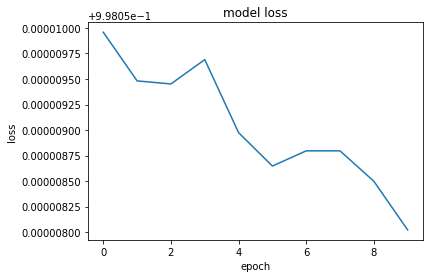

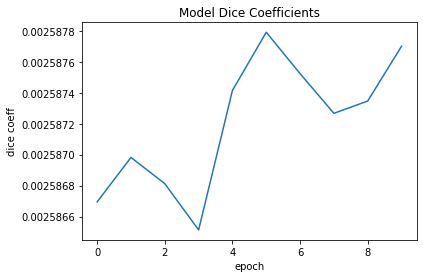

"plt.plot(history.history['weed_detection_rate'])\nplt.title('weed detection rate')\nplt.ylabel('detection_rate')\nplt.xlabel('epoch')\nplt.show()"

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#plt.plot(history.history['dice_loss'])
plt.plot(history.history['dice_coeff'])
plt.title('Model Dice Coefficients')
#plt.ylabel('dice loss')
plt.ylabel('dice coeff')
plt.xlabel('epoch')
plt.show()

'''plt.plot(history.history['weed_detection_rate'])
plt.title('weed detection rate')
plt.ylabel('detection_rate')
plt.xlabel('epoch')
plt.show()'''


# Step 7 - Test and graph results

In [ ]:
start_test_time = time.time()
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
test_time = time.time() - start_test_time

predictions = model.predict(x_test, batch_size=1, verbose=0)
weed_detection_rate = detection_rate(y_test, predictions, "weed")
crop_detection_rate = detection_rate(y_test, predictions, "crop")


In [ ]:
print("Train time: " + str(train_time) + " seconds")
print("Test time: " + str(test_time) + " seconds")
print('Test loss:', score[0])
print('Test dice coeff:', score[1])
print("weed detection rate:", weed_detection_rate)
print("crop detection rate:", crop_detection_rate)

Train time: 13.25031065940857 seconds
Test time: 0.3208284378051758 seconds
Test loss: 0.9974836111068726
Test dice coeff: 0.003356038825586438
weed detection rate: 0.0
crop detection rate: 0.0


In [ ]:
predictions *=255
x_test *= 255
y_test *= 255

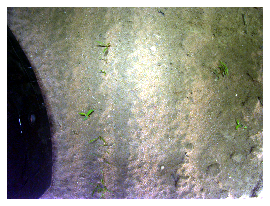

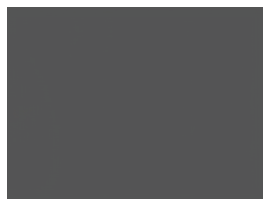

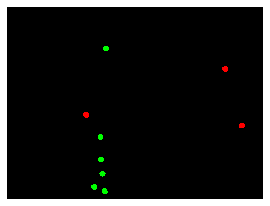

In [ ]:
n_samples = 1
#plot input images
plt.figure(figsize=(24,12))
for i in range(n_samples):
	plt.subplot(3, n_samples, 1+i)
	plt.axis('off')
	plt.imshow(x_test[i][SEQ_LENGTH-1].astype('uint8'))

#plot predictions
plt.figure(figsize=(24,12))
for i in range(n_samples):
	plt.subplot(3, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(predictions[i].astype('uint8'))

#plot ground truth images
plt.figure(figsize=(24,12))
for i in range(n_samples):
	plt.subplot(3, n_samples, 1 + 2*n_samples + i)
	plt.axis('off')
	plt.imshow(y_test[i].astype('uint8'))

plt.show()

In [ ]:
# Step 8 - Save model to json file


In [ ]:
'''model_name = "ConvLSTM"
model_json = model.to_json()
with open("/home/jupyter/Results/" + model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("/home/jupyter/Results/" + model_name + ".h5")
print("Saved model to disk")'''

'model_name = "ConvLSTM"\nmodel_json = model.to_json()\nwith open("/home/jupyter/Results/" + model_name + ".json", "w") as json_file:\n    json_file.write(model_json)\n    \n# serialize weights to HDF5\nmodel.save_weights("/home/jupyter/Results/" + model_name + ".h5")\nprint("Saved model to disk")'